In [9]:
# Define colors
Pitt.Blue<- "#003594"
Pitt.Gold<-"#FFB81C"
Pitt.DGray <- "#75787B"
Pitt.Gray <- "#97999B"
Pitt.LGray <- "#C8C9C7"
# ggplot preferences
library("ggplot2")
library("repr")

options(repr.plot.width=10, repr.plot.height=10/1.68)

Pitt.Theme<-theme( panel.background = element_rect(fill = "white", linewidth = 0.5, linetype = "solid"),
  panel.grid.major = element_line(linewidth = 0.5, linetype = 'solid', colour =Pitt.Gray), 
  panel.grid.minor = element_line(linewidth = 0.25, linetype = 'solid', colour = "white")
  )
base<- ggplot() + aes()+ Pitt.Theme

# Survival Models
---
Lifespans of various object are frequently targets of understanding. Examples include:
* Time to failure for a machine
* Lifespans of people
* Time durations until an event happens 
    * finding a job
    * buying a replacement product
    * losing a customer

From an [Industry article](https://www.analyticsvidhya.com/blog/2014/04/survival-analysis-model-you/) about survival analysis:
<blockquote>
Following are some industrial specific applications of survival analysis:
<ul>
<li> Banking – customer lifetime and LTV
<li>Insurance – time to lapsing on policy
<li>Mortgages – time to mortgage redemption
<li>Mail Order Catalogue – time to next purchase
<li>Retail – time till food customer starts purchasing non-food
<li>Manufacturing – lifetime of a machine component
<li>Public Sector – time intervals to critical events
</ul>
</blockquote>

While some economists use survival models to understand durations of unemployment or bid arrivals in auctions, I have not used them frequently myself. If you are interested, German Rodriguez at Princeton has a [more extensive course](https://data.princeton.edu/pop509) on this which I have followed for a brief overview. 

Demographers, Biostatisticians, and those in Health Sciences are greater users of these methods.

To set up some of the terms though let's go back to thinking of "the event" and look at deaths!

Actual deaths by age group and state: (downloaded from [mortality.org](https://usa.mortality.org/national.php?national=USA)) where the life tables include the following columns

|Variable | Description |
| --- | --- |
|  Year  |    Calendar year or range of years of occurrence |
| Age   |     Age group for n-year interval from exact age x to just before exact age x+n | 
| m(x)     |  Central death rate between age x and age x+n | 
| q(x)   |    Probability of death between age x and age x+n | 
| a(x)    |    Average length of survival between age x and age x+n for persons dying in the interval | 
| l(x)     |    Number of survivors at exact age x, assuming l(0) = 100,000 | 
| d(x)    |    Number of deaths between age x and age x+n | 
| L(x)  |      Number of person-years lived between age x and age x+n | 
| T(x)  |      Number of person-years remaining after exact age x | 
| e(x)   |     Life expectancy at exact age x (in years) = remaining length of life for survivors to age x | 

In [10]:
Mortality.US.m <- read.csv("hazards/USA_fltper_1x1.csv")
Mortality.US.f <- read.csv("hazards/USA_mltper_1x1.csv")
Mortality.US <- rbind(Mortality.US.m,Mortality.US.f)
Mortality.US <- subset(Mortality.US,  Age!="110+" )
Mortality.US['Age'] <- strtoi(Mortality.US$Age )+0.5 
head(Mortality.US)

,PopName,Sex,Year,Age,mx,qx,ax,lx,dx,Lx,Tx,ex
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,USA,f,1941,0.5,0.04318,0.04170,0.17,100000,4170,96556,6639911,66.40
2,USA,f,1941,1.5,0.00525,0.00524,0.50,95830,502,95579,6543356,68.28
3,USA,f,1941,2.5,0.00252,0.00252,0.50,95328,240,95208,6447776,67.64
4,USA,f,1941,3.5,0.00171,0.00171,0.50,95088,163,95007,6352568,66.81
5,USA,f,1941,4.5,0.00130,0.00130,0.50,94925,123,94864,6257561,65.92
6,USA,f,1941,5.5,0.00109,0.00108,0.50,94802,103,94751,6162697,65.01


### Surivival function:
Here we plot the survivors from an initial 100,000 births at age 0, for men and women, for the year 1960 and 2020. (the variable `lx`)

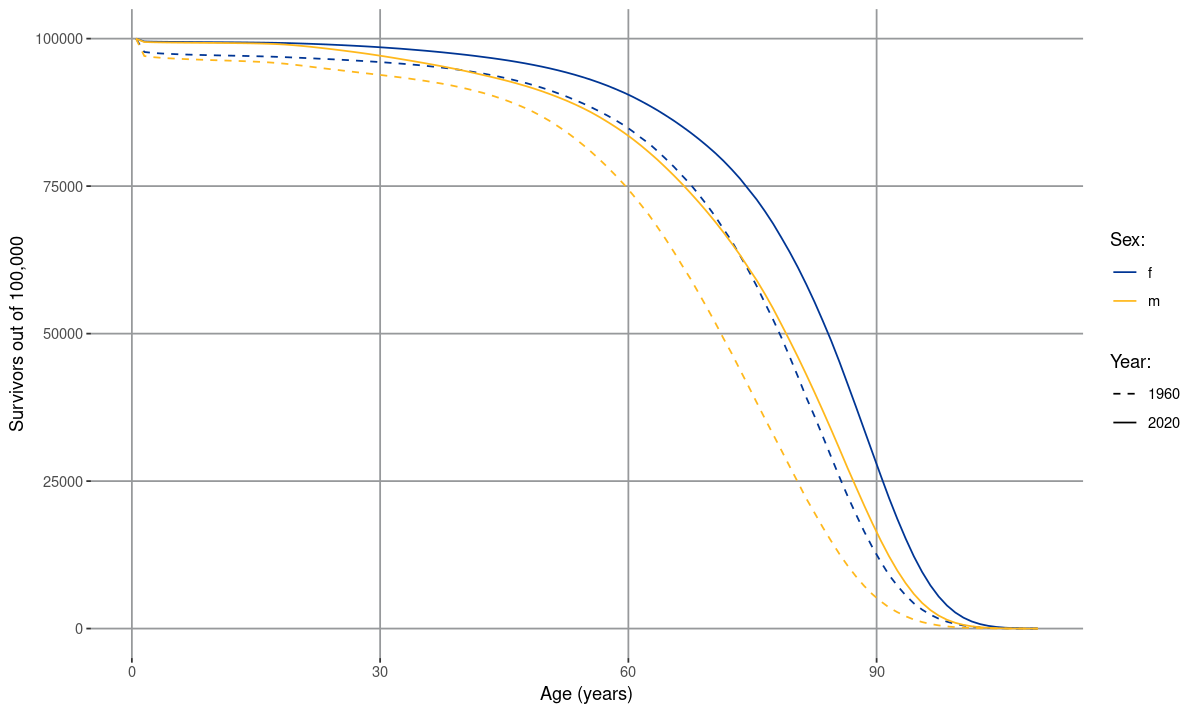

In [11]:
ggplot( data=subset(Mortality.US, (Year==1960 | Year== 2020)) ,aes(x=Age,y=lx,color=Sex, linetype=as.factor(Year)) )+
geom_line()+Pitt.Theme+scale_color_manual(name='Sex:', values=c("f"= Pitt.Blue, "m"= Pitt.Gold) )+
scale_linetype_manual(name='Year:', values=c("1960"= 2, "2020"= 1) )+xlab('Age (years)')+ylab('Survivors out of 100,000')

Here we can think of the point of death $T$ for a person as being a random variable with a CDF given by $F(t)$. 
* The CDF $F(t)$ therefore measures the probability that someone has died before age $t$.
* In contrast the quantity $1-F(t)$ measures the probability that someone is still alive at time $t$!

We will therefore call the amount $S(t)=1-F(t)$ the survival function, which is what we plotted above.

While the example we'll use is mortality for people, the event that we're modelling can be any event which happens at some point in time $t$.

## Hazards
The derivative of $F(t)$ (the density $f(t)$ for the event) provides us with the unconditional probability of an event occuring at any point in time, but the way data comes to us is often in the form of current survivors. 
* For these data-points the probability that they survived to time $t$ is given by $S(t)=1-F(t)$
* given that they have survived up to $t$, the conditional density for the event occuring for $t^\prime\geq t$ is given by $\frac{f(t^\prime)}{1-F(t)}=\frac{f(t^\prime)}{S(t)}$

The instantaneous risk of death at time $t$, conditional on survival to that point is therefore given by:
$$\lambda(t)=\frac{f(t)}{S(t)}$$
a feature of the data distribution we will call the the **hazard rate**.

Let's generate the hazard to human life in the US!

In [12]:
Mortality.US['lambda'] <- Mortality.US['qx']/(Mortality.US['lx'] /100000)
head(Mortality.US)

,PopName,Sex,Year,Age,mx,qx,ax,lx,dx,Lx,Tx,ex,lambda
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,USA,f,1941,0.5,0.04318,0.04170,0.17,100000,4170,96556,6639911,66.40,0.041700000
2,USA,f,1941,1.5,0.00525,0.00524,0.50,95830,502,95579,6543356,68.28,0.005468016
3,USA,f,1941,2.5,0.00252,0.00252,0.50,95328,240,95208,6447776,67.64,0.002643505
4,USA,f,1941,3.5,0.00171,0.00171,0.50,95088,163,95007,6352568,66.81,0.001798334
5,USA,f,1941,4.5,0.00130,0.00130,0.50,94925,123,94864,6257561,65.92,0.001369502
6,USA,f,1941,5.5,0.00109,0.00108,0.50,94802,103,94751,6162697,65.01,0.001139216


Illustrating these hazard rates:

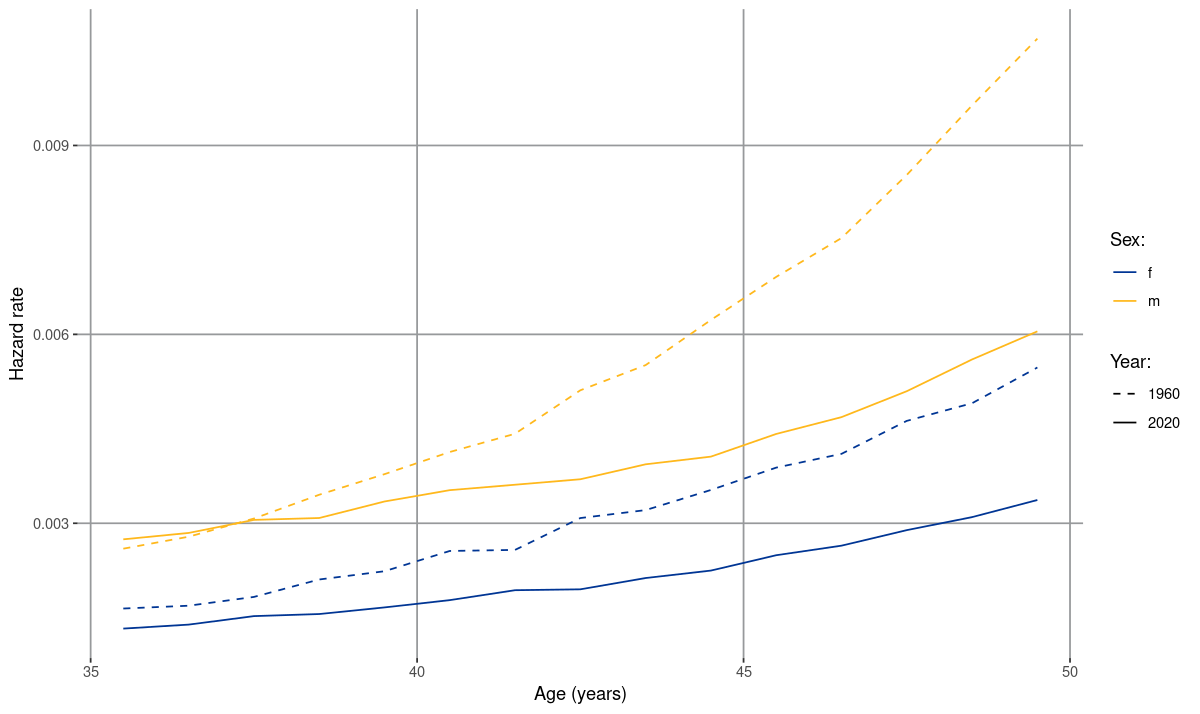

In [16]:
ggplot(data=subset(Mortality.US, (Year==1960 | Year== 2020)& Age>35 & Age<50) ,aes(x=Age,y=lambda,color=Sex, linetype=as.factor(Year)) )+geom_line()+Pitt.Theme+
scale_color_manual(name='Sex:', values=c("f"= Pitt.Blue, "m"= Pitt.Gold) ) +
scale_linetype_manual(name='Year:', values=c("1960"= 2, "2020"= 1) )+xlab('Age (years)')+ylab('Hazard rate')

The hazard is mathematically related to the Survival rate via:
$$ \lambda(t)=-\frac{\partial}{\partial t} \log\left(S(t)\right) $$
which means that the Survival function at any point $T$ can be written as:
$$ S(t)=\exp\left\{-\int^t_0 \lambda(s) ds\right\}$$

We will refer to the expression 
$$ \Lambda(t)=\int^t_0 \lambda(s) ds$$
as the **cumulative hazard**, where we can think of this as the sum of all of the risks we have faced across our lives from age 0 to age $t$.

From $ S(t)=\exp\left\{-\Lambda(t)\right\}$ we can also then say that:
$$\log(S(t))=-\Lambda(t) $$

## Constant Hazards
If the hazard rate is a constant, $\lambda(t)=\lambda$, this would mean that the CDF $F(t)$ must be given by:
 $$1-e^{-\lambda\cdot t},$$ 
which is precisely the CDF of an exponential distribution!
* This is the main characteristic of the exponential distribution, that it has a **constant hazard rate**, where survival up to time $t$ tells us nothing else about the subsequent chances!
* We can model hazards which move through time via a number of other distributions

In terms of our data if we have a single data point it has either:
* Had the event occur at time $t_i$
    * where the likelihood of this was $f(t_i)=\lambda(t_i)S(t_i)$
* Not had the event occur yet 
    * with likelihood of getting to $t_i=T$ or beyond given by $S(t_i)$

As such if we generate a dummy variable for whether the even has occured $e_i$ the likelihood of the data is given by:
$$L=\prod^n_{i=1}\lambda(t_i)^{e_i}S(t_i)$$
and so the log-likelihood is just:
$$l=\sum^n_{i=1}\log\left(S(t_i)\right) +e_i\log\left(\lambda(t_i)\right)=\sum^n_{i=1}\Lambda(t_i) +e_i\log\left(\lambda(t_i)\right)$$

Supposing that the underlying distribution was exponential, and the hazard rate a constant $\lambda(t)=\lambda$, the cumulative hazard is therefore linear $$\Lambda(t_i)=\lambda \cdot t_i$$

The log-likelihood divided by $N$ is :
$$\frac{l(\lambda)}{N}=\lambda \frac{1}{N}\sum^n_{i=1}t_i +\frac{N_e}{N}\log\left(\lambda\right)=\lambda\overline{T} + \eta_E\log(\lambda)$$
where $\eta_E=\frac{N_e}{N}$ is the fraction of the data that has had the event occur and $\overline{T}$ is the average observation time in the data

So under a constant hazard (i.e an exponential distribution!) the max-likelihood estimator is:
$$\lambda= -\frac{\eta_E}{\overline{T}}$$
the fraction of the data that has died, divided by the average observed time. 

*(N.B. if $E=1$ so that we observe the time of every event without censoring, the estimator is just the standard max-likelihood estimator for an exponential $\frac{1}{\overline{T}}$)* 

## Modeling effects
___

There are two main types of model that analysts use for survival data to incorporate predictive covariates:
1. Accelerated Time Models -  modeling the effects on the duration
2. Proportional Hazard Models - modeling the effects on the risks


### Accelerated Time Models
In these models the event-time outcome is modeled as:
$$\log(T_i)=x_i^T\beta+\sigma \epsilon$$
where we will chose the distribution for $\epsilon$ and assess this using max-likelihood.

So the failure time for object/person $i$ is modeled as:
$$ T_i=T^0_i\exp\left\{x_i^T\beta\right\}=T^0_i\cdot\eta_i$$
so that the estimated effects have a multiplicative relationship $\eta_i=\exp\left\{x_i^T\beta\right\}$ with the failure time.

This is called an accelerated time model, as the effect here is that for someone with $\eta_i=\exp\left\{x_i^T\beta\right\}=1$ their lifespan will be distributed according to the random variable $T^0_i=\exp\left\{\sigma \epsilon\right\}$. But someone with $\eta_i=2$ their lifespan will be distributed according to the variable $2T^0_i$.

The effect on time is that the survivor function will be $S(t_i/2)$ compared to $S(t_i)$ without the multiplier, so affecting the scale at which time affects things.

We therfore need to make some assumption about the noise.
* An exponential distribution baseline would make all of the hazards constant, just at different levels
* A common distributional assumption is a Weibull distribution, which has a nice inverse-S shaped survival distribution, that fits well with many applications
    * This distribution has a shape parameter that $k$ that allows for both linearly increasing and decreasing hazards 
    * An additional benefit is that Weibulls can also be interpreted as a proportional hazards model (see below)

## Weibull Distributions
In particular the Weibull distributions' survival function is given by:
$$ S(t) = \exp\left\{-(\lambda t)^k\right\} $$
for a scale parameter $\lambda$ that sets the rate at which time causes an effect, and a shape parameter $k$ that governs how quickly things fade off. 
* $k>1$ implies increasing risks with time
* $k<1$ decreasing risks with time

Illustrating the Weibull survival function:

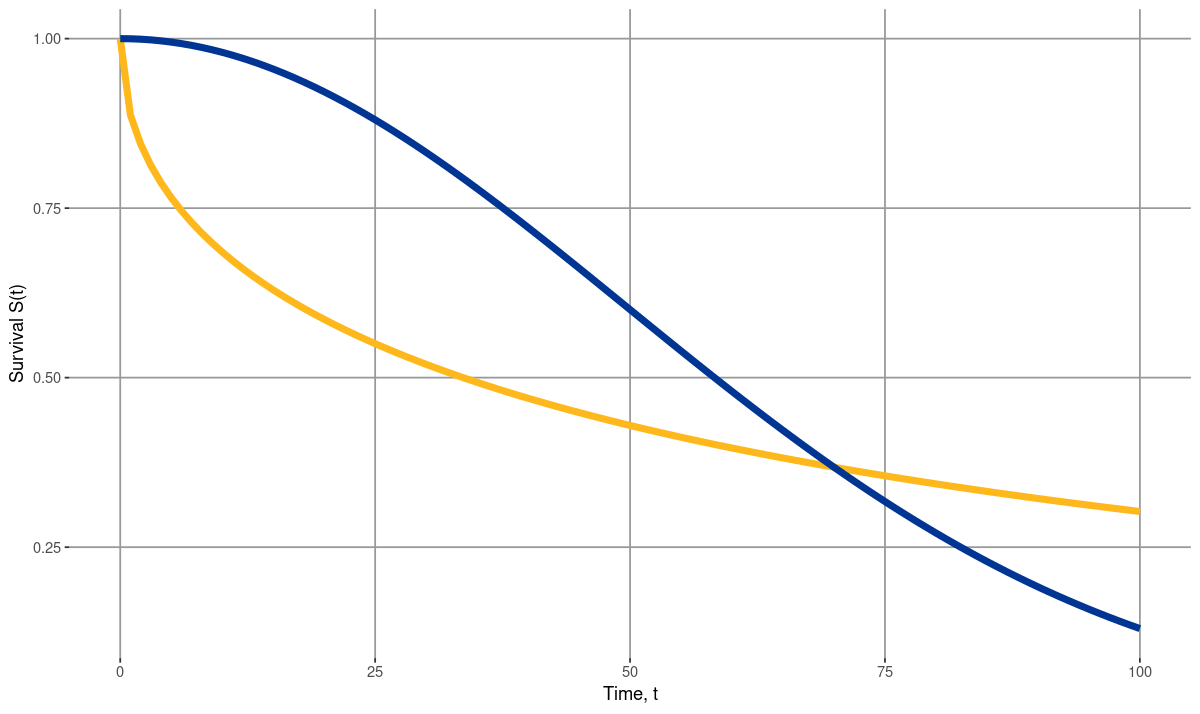

In [21]:
S.weibull <- function(t,lambda=1,k=1) exp(-(lambda*t)**k)
ggplot() + 
geom_function(fun=S.weibull, args=list(lambda=1/70,k=0.5),color=Pitt.Gold,linewidth=2)+
geom_function(fun=S.weibull, args=list(lambda=1/70,k=2),color=Pitt.Blue,linewidth=2)+
Pitt.Theme+xlim(0,100)+xlab('Time, t') + ylab('Survival S(t)')

### Example Estimation
If we make assumptions on the distribution of the event, we can therefore derive the hazard and Survival rates. By modeling the mean parameters of the distribution we can therefore fit a model with coavarites. Let's look at individualized data on whether an event occured within a certain duration, here defininig the event as committing a crime for a parolees:
(original data from [Wooldridge](https://www.stata.com/data/jwooldridge/eacsap/recid.dta))

In [22]:
load(file='hazards/recidivism.rdata')
head(recidivism)

,black,alcohol,drugs,super,married,felon,workprg,property,person,priors,educ,rules,age,tserved,follow,durat,cens,ldurat,fail
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<lgl>
1,0,1,0,1,1,0,1,0,0,0,7,2,441,30,72,72,1,4.276666,FALSE
2,1,0,0,1,0,1,1,1,0,0,12,0,307,19,75,75,1,4.317488,FALSE
3,0,0,0,0,0,0,1,1,0,0,9,5,262,27,81,9,0,2.197225,TRUE
4,0,0,1,1,0,1,1,1,0,2,9,3,253,38,76,25,0,3.218876,TRUE
5,0,0,1,1,0,0,0,0,0,0,9,0,244,4,81,81,1,4.394449,FALSE
6,1,0,0,1,0,0,1,0,0,1,12,0,277,13,79,79,1,4.369448,FALSE


To run an accelerated time survival model we use the survival package (obvs!), though this involves creating a survival object.

In [23]:
library(survival)

The reason we have to create this survival object is that our data here can be quite messy, where many outcomes that haven't failed will be right-censored, but sometimes even for the objects that have failed, we don't know exactly *when* they failed within the interval. 

Because this data is quite simple, we can get away with just telling it the `fail` outcome variable and the duration time variable (here `durat`).

In [24]:
recidivism["surv"] <- with(recidivism,Surv(durat, fail)) 
head(recidivism)

,black,alcohol,drugs,super,married,felon,workprg,property,person,priors,educ,rules,age,tserved,follow,durat,cens,ldurat,fail,surv
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<lgl>,<Surv>
1,0,1,0,1,1,0,1,0,0,0,7,2,441,30,72,72,1,4.276666,FALSE,"72, 0"
2,1,0,0,1,0,1,1,1,0,0,12,0,307,19,75,75,1,4.317488,FALSE,"75, 0"
3,0,0,0,0,0,0,1,1,0,0,9,5,262,27,81,9,0,2.197225,TRUE,"9, 1"
4,0,0,1,1,0,1,1,1,0,2,9,3,253,38,76,25,0,3.218876,TRUE,"25, 1"
5,0,0,1,1,0,0,0,0,0,0,9,0,244,4,81,81,1,4.394449,FALSE,"81, 0"
6,1,0,0,1,0,0,1,0,0,1,12,0,277,13,79,79,1,4.369448,FALSE,"79, 0"


You could also just use `Surv(durat,fail)` as the dependent variable when you run your model.

For more complicated environments you can use the Survival package to define interval censored data (for example, if you knew the failure occured in week 7, but not which day you could specify the interval $(49,56]$ for when the failure occurred.)

So something like:

``` with(df , Surv(leftInterval,rightInterval,type='interval')```

Once we have the survival object, we can estimate it with:

In [25]:
weibull.est <- survreg(surv~ workprg + priors + tserved + felon +
+   alcohol + drugs + black + married + educ + age, data=recidivism, dist="weibull")
summary(weibull.est)


Call:
survreg(formula = surv ~ workprg + priors + tserved + felon + 
    +alcohol + drugs + black + married + educ + age, data = recidivism, 
    dist = "weibull")
                Value Std. Error     z       p
(Intercept)  4.221670   0.341311 12.37 < 2e-16
workprg     -0.112785   0.112535 -1.00  0.3162
priors      -0.110176   0.017067 -6.46 1.1e-10
tserved     -0.016830   0.002130 -7.90 2.8e-15
felon        0.371623   0.131995  2.82  0.0049
alcohol     -0.555132   0.132243 -4.20 2.7e-05
drugs       -0.349265   0.121880 -2.87  0.0042
black       -0.563016   0.110817 -5.08 3.8e-07
married      0.188104   0.135752  1.39  0.1659
educ         0.028911   0.024115  1.20  0.2306
age          0.004622   0.000665  6.95 3.6e-12
Log(scale)   0.215840   0.038915  5.55 2.9e-08

Scale= 1.24 

Weibull distribution
Loglik(model)= -3192.1   Loglik(intercept only)= -3274.8
	Chisq= 165.48 on 10 degrees of freedom, p= 2.4e-30 
Number of Newton-Raphson Iterations: 5 
n= 1445 


Note here a slight difference in notation for the `survreg` command where
* `Scale`=$\frac{1}{k}$ from the Weibull definition
* `(Intercept)` is $\log(\lambda)$ from the Weibull definition

So here the effect of an additional year of time served is to decrease the duration of not reoffending by approximately 18 percent:

In [26]:
exp( weibull.est$coefficients['tserved']*12 )-1

tserved 
-0.1828696

Being ten-years older increases the duration by approximately 5 percent:

In [27]:
exp(weibull.est$coefficients['age']*10)-1

age 
0.04730359

Other distributions for the error can easily be incorporated into the estimation:

In [28]:
lognormal.est <- survreg(surv ~ workprg + priors + tserved + felon  + alcohol + drugs + black + married + educ + age, 
                         data=recidivism, dist="lognormal")
summary(lognormal.est)


Call:
survreg(formula = surv ~ workprg + priors + tserved + felon + 
    alcohol + drugs + black + married + educ + age, data = recidivism, 
    dist = "lognormal")
                Value Std. Error     z       p
(Intercept)  4.099386   0.347535 11.80 < 2e-16
workprg     -0.062572   0.120037 -0.52  0.6022
priors      -0.137253   0.021459 -6.40 1.6e-10
tserved     -0.019331   0.002978 -6.49 8.5e-11
felon        0.443995   0.145087  3.06  0.0022
alcohol     -0.634909   0.144217 -4.40 1.1e-05
drugs       -0.298160   0.132736 -2.25  0.0247
black       -0.542718   0.117443 -4.62 3.8e-06
married      0.340684   0.139843  2.44  0.0148
educ         0.022920   0.025397  0.90  0.3668
age          0.003910   0.000606  6.45 1.1e-10
Log(scale)   0.593586   0.034412 17.25 < 2e-16

Scale= 1.81 

Log Normal distribution
Loglik(model)= -3156.1   Loglik(intercept only)= -3239.5
	Chisq= 166.74 on 10 degrees of freedom, p= 1.3e-30 
Number of Newton-Raphson Iterations: 4 
n= 1445 


And in fact the log-normal fits the data slightly better:

In [29]:
AIC(lognormal.est)
AIC(weibull.est)

[1] 6336.271

[1] 6408.218

For further details on these models, and choices for the distributions you will have to look to more [advanced sources](http://doi.org/10.1002/9781118032985) and or [deeper into the manual](https://cran.r-project.org/web/packages/survival/vignettes/survival.pdf#page=79#) for the package details and vignettes.

### Proportional Hazard Models
The other common approach to modeling the data is for the model to have proportional effects via the hazard rate (scaling up and down the risks, instead of the duration/timescale). This model has that the hazard rate for person $i$ (conditional on their observables $x_i$) is given by:
$$\lambda_i(t|x_i)=\lambda_0(t)\cdot\exp\left\{x_i^T\beta\right\} $$
where we would then be free to incorporate whichever terms we wanted into the model as demanded by the question.

The model is therefore comprised of:
* A baseline hazard rate for someone with $x_i=0$ (for every single variable)
* A multiplicative relationship in the other variables through $\exp\left\{x_i^T\beta\right\}=\prod^K_{k=1}\exp\left\{x_{ik}^T\beta_k\right\}$
    * Variable $k$ therefore scales up or down the hazard by $\exp\left\{x_{ik}^T\beta_k\right\}$ depending on whether $x_{ik}\beta_k$ is positive or negative

One nice thing about the proportional approach is that the cumulative hazard is similarly proportional as the multiplier is constant over time:
$$\Lambda_i(t|x_i)=\int^t_0\lambda_0(s)\cdot\exp\left\{x_i^T\beta\right\}ds=\Lambda_0(t)\exp\left\{x_i^T\beta\right\}$$
which given the relationship between the cumulative hazard and survival function means that we have:
$$ S(t|x_i)=S_0(t)^{\eta_i}$$
* where $S_0(t)$ is the baseline survivor function $S_0(t)=\exp\left\{-\Lambda_0(t)\right\}$
* and $\eta_i=\exp\left\{x_i^T\beta\right\}$ is the net multiplier of the risks, which enter here as a power.

One of the main ways people estimate theses models is to create a partial likelihood function that allows the baseline hazard rate to be unspecified. This method is referred to as a Cox Proportional Hazard model, and it can be estimted with the `coxph` command in R.

In [30]:
cox.est <- coxph( Surv(durat,fail) ~ workprg + priors + tserved + felon +
+   alcohol + drugs + black + married + educ + age, data=recidivism)
summary(cox.est)

Call:
coxph(formula = Surv(durat, fail) ~ workprg + priors + tserved + 
    felon + +alcohol + drugs + black + married + educ + age, 
    data = recidivism)

  n= 1445, number of events= 552 

              coef  exp(coef)   se(coef)      z Pr(>|z|)    
workprg  0.0844047  1.0880692  0.0908109  0.929  0.35265    
priors   0.0880165  1.0920062  0.0134634  6.537 6.26e-11 ***
tserved  0.0130652  1.0131509  0.0016827  7.765 8.20e-15 ***
felon   -0.2839037  0.7528391  0.1061160 -2.675  0.00746 ** 
alcohol  0.4329985  1.5418739  0.1057236  4.096 4.21e-05 ***
drugs    0.2776044  1.3199639  0.0978660  2.837  0.00456 ** 
black    0.4350647  1.5450631  0.0883757  4.923 8.53e-07 ***
married -0.1551368  0.8562981  0.1092094 -1.421  0.15545    
educ    -0.0213612  0.9788653  0.0194458 -1.099  0.27198    
age     -0.0036055  0.9964010  0.0005228 -6.896 5.34e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

        exp(coef) exp(-coef) lower .95 upper .95
workprg    1.0881  

The effect of an additional year of time served therefore has a multiplicative effect on the riskiness of reoffending given by:

In [31]:
exp(12*cox.est$coefficients['tserved'])-1

tserved 
0.1697404

So increasing the risk factors by 17 percent!

Similarly, going back to being 10 years older when you were released the effect is:

In [32]:
exp(10*cox.est$coefficients['age'])-1

age 
-0.03541256

So decreasing the risks by 3.5 percent.

Prediction then involves understanding the risk factors

In [34]:
recidivism["lin.pred"] <- predict(cox.est,type="lp")
recidivism["exp.events"] <- predict(cox.est,type="expected") 
recidivism["risk.mult"] <- predict(cox.est,typ e="risk")
tail(recidivism)

,black,alcohol,drugs,super,married,felon,workprg,property,person,priors,⋯,tserved,follow,durat,cens,ldurat,fail,surv,lin.pred,exp.events,risk.mult
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<dbl>,<lgl>,<Surv>,<dbl>,<dbl>,<dbl>
1440,0,0,1,0,0,0,0,0,0,0,⋯,12,72,3,0,1.098612,TRUE,"3, 1",0.4032354,0.0207713,1.4966591
1441,0,1,1,1,0,0,0,0,0,0,⋯,8,80,80,1,4.382027,FALSE,"80, 0",0.2179130,0.4295149,1.2434789
1442,1,0,0,1,1,1,0,1,0,0,⋯,12,73,73,1,4.290460,FALSE,"73, 0",-0.2713420,0.2601435,0.7623557
1443,1,0,0,0,0,0,1,0,0,0,⋯,36,81,81,1,4.394449,FALSE,"81, 0",0.8790720,0.8319858,2.4086634
1444,0,0,0,1,1,0,1,0,0,0,⋯,9,81,81,1,4.394449,FALSE,"81, 0",-0.4818526,0.2133408,0.6176381
1445,0,0,0,1,0,0,0,0,0,0,⋯,13,72,72,1,4.276666,FALSE,"72, 0",0.1664535,0.4015659,1.1811086


Alternatively the `terms` prediction can be used to show you how each variable affects the risks multiplicativey (here as a percentage increase/decrease:)

In [35]:
head(round(100*(exp(predict(cox.est,type="terms"))-1),1))

,workprg,priors,tserved,felon,alcohol,drugs,black,married,educ,age
1,8.8,-11.8,15.2,0.0,54.2,0,0.0,-14.4,5.9,-29.1
2,8.8,-11.8,-0.2,-24.7,0.0,0,54.5,0.0,-4.8,14.9
3,8.8,-11.8,10.8,0.0,0.0,0,0.0,0.0,1.5,35.1
4,8.8,5.1,27.9,-24.7,0.0,32,0.0,0.0,1.5,39.6
5,0.0,-11.8,-18.0,0.0,0.0,32,0.0,0.0,1.5,44.2
6,8.8,-3.7,-7.8,0.0,0.0,0,54.5,0.0,-4.8,28.0
